# General Info

This notebook produces figures 7a and 7b. However, as a light-weight default, only 7a is selected. If you also want to test 7a, you can change the `tls_mode` below to "no_quic" (index \[0\]) and completely rerun this notebook. 

# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from matplotlib.ticker import MultipleLocator

# Analysis Mode

In [2]:
# default will plot the only-quic dependency plot
# the no_quic data set is larger and takes ~3 of minutes
tls_mode = ["no_quic", "only_quic"][1]

# Load Dataframes

In [3]:
df_quic = pd.read_pickle(f"../data/pkl/df_quicreach_handshakes.pkl.zst")
df_quic.head()

,domain,rtt,sent_tls_payload,recv_tls_payload,handshake_tag,sent_udp_payload,recv_udp_payload,ampl_factor,initial_size
0,0-1xbet.best,8.486000,288,2656,Amplification,1220,5118,4.2,1200
1,0-1xbet.best,16.799999,288,2654,Amplification,1220,5116,4.2,1212
2,0-1xbet.best,23.701000,288,2656,Amplification,1222,5118,4.2,1222
3,0-1xbet.best,8.466000,288,2655,Amplification,1232,5117,4.2,1232
4,0-1xbet.best,10.727000,288,2656,Amplification,1242,5118,4.1,1242


In [4]:
df_tls = pd.read_pickle(f"../data/pkl/df_tls_certs.pkl.zst")
df_tls.head()

,domain,type,d,dt,certsize,tbssize,subjcn,subjhash,subjk,subjsize,...,sansize,sctcount,sctsize,extssize,sigalg,sigsize,validation,precert,ca,hash
0,0-1.ir,INTM,0,2,1380,1100,ISRG Root X1,281aea4e6a11200e3949b766237385489c2e8792,79b459e67bb6e5e40173800888c81a58f6e99b6e,81,...,0,0,0,248,SHA256-RSA,256,DV,False,True,6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c2...
1,0-1.ir,INTM,1,2,1306,770,R3,48dac9a0fb2bd32d4ff0de68d2f567b735f9b3c4,142eb317b75856cbae500940e61faf9d8b14c2c6,52,...,0,0,0,177,SHA256-RSA,512,DV,False,True,67add1166b020ae61b8f5fc96813c04c2aa58996079686...
2,0-1.ir,LEAF,2,2,1315,1035,0-1.ir,54a78fa9554bdf23acf9f904cbf1f829a6e95693,259e6544d8a23a946330daab01dd4464028b85d7,19,...,22,2,246,484,SHA256-RSA,256,DV,False,False,7bec3730cd02e1f9be61e4db036f028c2d6d4a81d9480b...
3,0-11-0.com,LEAF,0,0,1288,1008,www.stackssl.com,21b145e103c2e1465e6c7e68de0c2f9b59a3501b,c1de76d0eb2484971f8e1657e26f5ae3388d0921,29,...,20,0,0,440,SHA256-RSA,256,DV,False,False,f9cc586e274a96227aa09eca83052843b76fca404faa3b...
4,0-1xbet.best,INTM,0,1,977,697,Cloudflare Inc ECC CA-3,12d78b402c356206fa827f8ed8922411b4acf504,a5ce37eaebb0750e946788b445fad9241087961f,76,...,0,0,0,273,SHA256-RSA,256,OV,False,True,3abbe63daf756c5016b6b85f52015fd8e8acbe277c5087...


In [5]:
# adjust dataframe to TLS mode
if tls_mode == "only_quic":
    df_tls = df_tls[df_tls["domain"].isin(df_quic["domain"].drop_duplicates().values)]
elif tls_mode == "no_quic":
    df_tls = df_tls[~df_tls["domain"].isin(df_quic["domain"].drop_duplicates().values)]
else:
    print("--- WARNING UNSUPPORTED TLS MODE ---")

In [6]:
df_compression = pd.read_pickle(f"../data/pkl/df_compression.pkl.zst")

# Figure 7: Certificate chain sizes, depths and their dependency

### Sanitize Unordered Cert Chains

In [7]:
# make sure we have a sorted dataframe since we will shift rows based on depth
df_tls = df_tls.sort_values(by=["domain","d"])

In [8]:
# --> for each domain, shift by 1 to check the chain
set_unordered_domains = set()
def check_cert_order(subdf, set_unordered):
    
    ordered = all(subdf["subjk"].head(-1).values == 
               subdf["issk"].tail(-1).values)
    
    if not ordered:      
        domain = subdf["domain"].values[0]
        set_unordered |= {domain}
        
    return ordered

subdf_col = ["domain","d","subjk", "issk", "hash"]
df_tls.groupby(["domain"])[subdf_col].apply(check_cert_order, set_unordered=set_unordered_domains).value_counts()

True     271733
False       523
dtype: int64

In [9]:
remove_complex_cases = True
if remove_complex_cases:  # neglible
    df_tls = df_tls[~df_tls["domain"].isin(set_unordered_domains)]

### Calculate Leaf Dependency 

In [10]:
df_tls_nonleafs = df_tls[df_tls["type"]!="LEAF"]

In [11]:
df_chains = df_tls_nonleafs.groupby(["domain"]).agg({
    "hash":tuple, "certsize":tuple})
df_chains.head()

,hash,certsize
domain,,
0-1xbet.best,(3abbe63daf756c5016b6b85f52015fd8e8acbe277c508...,"(977,)"
0-1xbet.club,(6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c...,"(1380, 1124, 714)"
0-1xbet.info,(3abbe63daf756c5016b6b85f52015fd8e8acbe277c508...,"(977,)"
0-1xbet.top,(3abbe63daf756c5016b6b85f52015fd8e8acbe277c508...,"(977,)"
0-1xbet.xyz,(3abbe63daf756c5016b6b85f52015fd8e8acbe277c508...,"(977,)"


In [12]:
print(f"All leaf certs depend on {df_chains['hash'].nunique()} unique parent chains.")

All leaf certs depend on 231 unique parent chains.


In [13]:
df_fingerprint = df_chains.value_counts().reset_index(name="num_domains")
df_fingerprint["share_domains"] = df_fingerprint["num_domains"]/df_tls_nonleafs["domain"].nunique()*100

df_fingerprint["share_domains_str"] = df_fingerprint["share_domains"].apply(
                                        lambda fl: "{0:0.2f}".format(fl))

In [14]:
# show most common parent chains
df_fingerprint_cut = df_fingerprint.head(10).copy()
df_fingerprint_cut

,hash,certsize,num_domains,share_domains,share_domains_str
0,(3abbe63daf756c5016b6b85f52015fd8e8acbe277c508...,"(977,)",167220,61.542651,61.54
1,(6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c...,"(1380, 1124, 714)",45658,16.803698,16.80
2,(6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c...,"(1380, 1306)",28024,10.313786,10.31
3,(38392f17ce7b682c198d29c6e71d2740964a2074c8d25...,"(1410, 1525)",5144,1.893167,1.89
4,(3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd...,"(1382, 1424)",4156,1.529549,1.53
5,(67add1166b020ae61b8f5fc96813c04c2aa5899607968...,"(1306,)",3464,1.274870,1.27
6,(3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd...,"(1382, 1424)",2802,1.031231,1.03
7,(09bc1b137c031239ef788673e94eb17f5f3ecab07d3ad...,"(1161,)",2500,0.920085,0.92
8,(68b9c761219a5b1f0131784474665db61bbdb109e00f0...,"(1413, 1559)",2246,0.826604,0.83
9,(3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd...,"(1382, 1434)",999,0.367666,0.37


In [15]:
# get all domains for most common parent chains
# use them to infer median and max leaf cert sizes
dict_leaf_domains = df_chains.reset_index().groupby(["hash"])["domain"].unique().to_dict()

df_fingerprint_cut["max_leaf"] = df_fingerprint_cut["hash"].apply(
    lambda chain: df_tls[ (df_tls["domain"].isin(dict_leaf_domains[chain])) & 
                        (df_tls["type"]=="LEAF")]["certsize"].max())

df_fingerprint_cut["median_leaf"] = df_fingerprint_cut["hash"].apply(
    lambda chain: df_tls[ (df_tls["domain"].isin(dict_leaf_domains[chain])) & 
                        (df_tls["type"]=="LEAF")]["certsize"].median())

df_fingerprint_cut

,hash,certsize,num_domains,share_domains,share_domains_str,max_leaf,median_leaf
0,(3abbe63daf756c5016b6b85f52015fd8e8acbe277c508...,"(977,)",167220,61.542651,61.54,2620,1342.0
1,(6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c...,"(1380, 1124, 714)",45658,16.803698,16.80,1244,975.0
2,(6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c...,"(1380, 1306)",28024,10.313786,10.31,3870,1329.0
3,(38392f17ce7b682c198d29c6e71d2740964a2074c8d25...,"(1410, 1525)",5144,1.893167,1.89,15227,1686.0
4,(3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd...,"(1382, 1424)",4156,1.529549,1.53,1626,1401.0
5,(67add1166b020ae61b8f5fc96813c04c2aa5899607968...,"(1306,)",3464,1.274870,1.27,4605,1351.0
6,(3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd...,"(1382, 1424)",2802,1.031231,1.03,3636,1422.0
7,(09bc1b137c031239ef788673e94eb17f5f3ecab07d3ad...,"(1161,)",2500,0.920085,0.92,1652,1618.0
8,(68b9c761219a5b1f0131784474665db61bbdb109e00f0...,"(1413, 1559)",2246,0.826604,0.83,2651,1502.0
9,(3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd...,"(1382, 1434)",999,0.367666,0.37,10028,1354.0


In [16]:
print(f"Top parent chains are responsible for {df_fingerprint_cut['share_domains'].sum()} % of domains.")

Top parent chains are responsible for 96.50330862598172 % of domains.


In [17]:
# only continue if this is true, otherwise we produce wrong groups due to explode()
assert(df_fingerprint_cut["share_domains"].nunique() == len(df_fingerprint_cut))

### Annotate and Visualize

In [18]:
df_exp = df_fingerprint_cut.explode(["hash","certsize"])

In [19]:
df_pivot = df_exp.pivot(index="share_domains", columns="hash", values="certsize")

# heuristic --> sort by cert depth (definitely double check, but seems to work! :)
col_order = list(df_tls[df_tls["hash"].isin(set(df_pivot.columns))]\
                 .groupby(["hash"])["d"].mean().sort_values().index)

df_pivot = df_pivot[col_order]
df_pivot.head()

hash,09bc1b137c031239ef788673e94eb17f5f3ecab07d3adbfb485e75abfaaf3b9a,38392f17ce7b682c198d29c6e71d2740964a2074c8d2558e6cff64c27823f129,3abbe63daf756c5016b6b85f52015fd8e8acbe277c5087b127a60563a841ed8a,3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd94c24efd769133918e5,6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c2f99b9d47cf7ff1c24f,68b9c761219a5b1f0131784474665db61bbdb109e00f05ca9f74244ee5f5f52b,67add1166b020ae61b8f5fc96813c04c2aa589960796865572a3c7e737613dfd,8b05b68cc659e5ed0fcb38f2c942fbfd200e6f2ff9f85d63c6994ef5e0b02701,23ecb03eec17338c4e33a6b48a41dc3cda12281bbc3ff813c0589d6cc2387522,64e286b76063602a372efd60cde8db2656a49ee15e84254b3d6eb5fe38f4288b,821cc55ce7ec5c74febb42f624eb6a36c478215a31ed67e3cf723a67e8c75eba,97d42003e132552946097f20ef955f5b1cd570aa4372d780033a65efbe69758d,7fa4ff68ec04a99d7528d5085f94907f4d1dd1c5381bacdc832ed5c960214676,46494e30379059df18be52124305e606fc59070e5b21076ce113954b60517cda
share_domains,,,,,,,,,,,,,,
0.367666,NaN,NaN,NaN,1382,NaN,NaN,NaN,NaN,1434,NaN,NaN,NaN,NaN,NaN
0.826604,NaN,NaN,NaN,NaN,NaN,1413,NaN,NaN,NaN,NaN,NaN,NaN,1559,NaN
0.920085,1161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.031231,NaN,NaN,NaN,1382,NaN,NaN,NaN,NaN,NaN,1424,NaN,NaN,NaN,NaN
1.274870,NaN,NaN,NaN,NaN,NaN,NaN,1306,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# map share_domains index to median and max leaf
dict_share_medians = df_exp.groupby(["share_domains"])["median_leaf"].first()
df_pivot["median_leaf"] = df_pivot.index.map(dict_share_medians)

dict_share_max = df_exp.groupby(["share_domains"])["max_leaf"].first()
df_pivot["max_leaf"] = df_pivot.index.map(dict_share_max)
df_pivot["max_leaf"] -= df_pivot["median_leaf"]

df_pivot

hash,09bc1b137c031239ef788673e94eb17f5f3ecab07d3adbfb485e75abfaaf3b9a,38392f17ce7b682c198d29c6e71d2740964a2074c8d2558e6cff64c27823f129,3abbe63daf756c5016b6b85f52015fd8e8acbe277c5087b127a60563a841ed8a,3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd94c24efd769133918e5,6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c2f99b9d47cf7ff1c24f,68b9c761219a5b1f0131784474665db61bbdb109e00f05ca9f74244ee5f5f52b,67add1166b020ae61b8f5fc96813c04c2aa589960796865572a3c7e737613dfd,8b05b68cc659e5ed0fcb38f2c942fbfd200e6f2ff9f85d63c6994ef5e0b02701,23ecb03eec17338c4e33a6b48a41dc3cda12281bbc3ff813c0589d6cc2387522,64e286b76063602a372efd60cde8db2656a49ee15e84254b3d6eb5fe38f4288b,821cc55ce7ec5c74febb42f624eb6a36c478215a31ed67e3cf723a67e8c75eba,97d42003e132552946097f20ef955f5b1cd570aa4372d780033a65efbe69758d,7fa4ff68ec04a99d7528d5085f94907f4d1dd1c5381bacdc832ed5c960214676,46494e30379059df18be52124305e606fc59070e5b21076ce113954b60517cda,median_leaf,max_leaf
share_domains,,,,,,,,,,,,,,,,
0.367666,NaN,NaN,NaN,1382,NaN,NaN,NaN,NaN,1434,NaN,NaN,NaN,NaN,NaN,1354.0,8674.0
0.826604,NaN,NaN,NaN,NaN,NaN,1413,NaN,NaN,NaN,NaN,NaN,NaN,1559,NaN,1502.0,1149.0
0.920085,1161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1618.0,34.0
1.031231,NaN,NaN,NaN,1382,NaN,NaN,NaN,NaN,NaN,1424,NaN,NaN,NaN,NaN,1422.0,2214.0
1.274870,NaN,NaN,NaN,NaN,NaN,NaN,1306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1351.0,3254.0
1.529549,NaN,NaN,NaN,1382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1424,NaN,NaN,1401.0,225.0
1.893167,NaN,1410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1525,NaN,NaN,NaN,1686.0,13541.0
10.313786,NaN,NaN,NaN,NaN,1380,NaN,1306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1329.0,2541.0
16.803698,NaN,NaN,NaN,NaN,1380,NaN,NaN,1124,NaN,NaN,NaN,NaN,NaN,714,975.0,269.0


In [21]:
# [RH] meta information for certs, improves annotation
dict_fingerprint_meta = {
    "6d99fb265eb1c5b3744765fcbc648f3cd8e1bffafdc4c2f99b9d47cf7ff1c24f": {
        "label": "ISRG Root X1",
        "organization": "Internet Security Research Group",
        "position": "root",
        "description": "issued by Digital Signature Trust Co.",
        "reference": "https://letsencrypt.org/certificates/",
        "short": "Let's Enc. X1",
    },
    "67add1166b020ae61b8f5fc96813c04c2aa589960796865572a3c7e737613dfd": {
        "label": "R3",
        "organization": "Internet Security Research Group",
        "position": "intermediate",
        "description": "Let's Encrypt (Intermediate R3)",
        "reference": "https://letsencrypt.org/certificates/",
        "short": "Let's Enc. R3",
    },
    "68b9c761219a5b1f0131784474665db61bbdb109e00f05ca9f74244ee5f5f52b": {
        "label": "USERTrust RSA Certification Authority",
        "organization": "The USERTRUST Network",
        "position": "intermediate",
        "description": "issued Comodo CA Limited",
        "reference": "https://crt.sh/?sha256=68b9c761219a5b1f0131784474665db61bbdb109e00f05ca9f74244ee5f5f52b",
        "short": "USERTRUST",
    },
    "15eb0a75c673abfbdcd2fafc02823c91fe6cbc36e00788442c8754d72bec3717": {
        "label": "Encryption Everywhere DV TLS CA - G1",
        "organization": "DigiCert Inc",
        "position": "intermediate",
        "description": "issued by DigiCert Root CA",
        "reference": "https://crt.sh/?q=15eb0a75c673abfbdcd2fafc02823c91fe6cbc36e00788442c8754d72bec3717",
        "short": "DigiCert",
    },
    "3abbe63daf756c5016b6b85f52015fd8e8acbe277c5087b127a60563a841ed8a": {
        "label": "Cloudflare Inc ECC CA-3",
        "organization": "Cloudflare, Inc.",
        "position": "intermediate",
        "description": "issued by CyberTrust",
        "reference": "https://crt.sh/?q=3abbe63daf756c5016b6b85f52015fd8e8acbe277c5087b127a60563a841ed8a",
        "short": "Cloudflare",
    },
    "38392f17ce7b682c198d29c6e71d2740964a2074c8d2558e6cff64c27823f129": {
        "label": "COMODO RSA Certification Authority",
        "organization": "COMODO CA Limited",
        "position": "intermediate",
        "description": "issued by Comodo",
        "reference": "https://crt.sh/?q=38392f17ce7b682c198d29c6e71d2740964a2074c8d2558e6cff64c27823f129",
        "short": "Comodo",
    },
    "821cc55ce7ec5c74febb42f624eb6a36c478215a31ed67e3cf723a67e8c75eba": {
        "label": "cPanel, Inc. Certification Authority",
        "organization": "cPanel, Inc.",
        "position": "intermediate",
        "description": "issued by Comodo",
        "reference": "https://ssl-tools.net/subjects/93b9fa878a7aee4bf3fd5a2d574a3451ce84cb7c",
        "short": "cPanel",
    },
    "7fa4ff68ec04a99d7528d5085f94907f4d1dd1c5381bacdc832ed5c960214676": {
        "label": "Sectigo RSA Domain Validation Secure Server CA",
        "organization": "Sectigo Limited",
        "position": "intermediate",
        "description": "issed by USERTRUST",
        "reference": "https://crt.sh/?q=7fa4ff68ec04a99d7528d5085f94907f4d1dd1c5381bacdc832ed5c960214676",
        "short": "Sectigo",
    },
    "28689b30e4c306aab53b027b29e36ad6dd1dcf4b953994482ca84bdc1ecac996": {
        "label": "Starfield Services Root Certificate Authority - G2",
        "organization": "Starfield Technologies, Inc.",
        "position": "intermediate",
        "description": "issued by Starfield Technologies",
        "reference": "https://crt.sh/?q=28689b30e4c306aab53b027b29e36ad6dd1dcf4b953994482ca84bdc1ecac996",
        "short": "Starfield",
    },
    "87dcd4dc74640a322cd205552506d1be64f12596258096544986b4850bc72706": {
        "label": "Amazon Root CA 1",
        "organization": "Amazon",
        "position": "intermediate",
        "description": "issued by Starfield Technologies (G2)",
        "reference": "https://crt.sh/?q=87dcd4dc74640a322cd205552506d1be64f12596258096544986b4850bc72706",
        "short": "Amazon",
    },
    "f55f9ffcb83c73453261601c7e044db15a0f034b93c05830f28635ef889cf670": {
        "label": "Amazon",
        "organization": "Amazon",
        "position": "intermediate",
        "description": "issued by Amazon Root CA 1",
        "reference": "https://crt.sh/?q=f55f9ffcb83c73453261601c7e044db15a0f034b93c05830f28635ef889cf670",
        "short": "Amazon",
    },
    "d7a7a0fb5d7e2731d771e9484ebcdef71d5f0c3e0a2948782bc83ee0ea699ef4": {
        "label": "AAA Certificate Services",
        "organization": "Comodo CA Limited",
        "position": "root",
        "description": "",
        "reference": "https://crt.sh/?q=d7a7a0fb5d7e2731d771e9484ebcdef71d5f0c3e0a2948782bc83ee0ea699ef4",
        "short": "Comodo (Root)",
    },
    "973a41276ffd01e027a2aad49e34c37846d3e976ff6a620b6712e33832041aa6": {
        "label": "Go Daddy Secure Certificate Authority - G2",
        "organization": "GoDaddy.com, Inc.",
        "position": "intermediate",
        "description": "signed by GoDaddy Root",
        "reference": "https://crt.sh/?q=973a41276ffd01e027a2aad49e34c37846d3e976ff6a620b6712e33832041aa6",
        "short": "GoDaddy",
    },
    "52274c57ce4dee3b49db7a7ff708c040f771898b3be88725a86fb4430182fe14": {
        "label": "DigiCert TLS RSA SHA256 2020 CA1",
        "organization": "DigiCert Inc",
        "position": "intermediate",
        "description": "issued by DigiCert Root",
        "reference": "https://crt.sh/?q=52274c57ce4dee3b49db7a7ff708c040f771898b3be88725a86fb4430182fe14",
        "short": "DigiCert",
    },
    "8b05b68cc659e5ed0fcb38f2c942fbfd200e6f2ff9f85d63c6994ef5e0b02701": {
        "label": "ISRG Root X2",
        "organization": "Internet Security Research Group",
        "position": "itermediate",
        "description": "Let's Encrypt (Root X2)",
        "reference": "https://letsencrypt.org/certificates/",
        "short": "Let's Enc. X2",
    },
    "46494e30379059df18be52124305e606fc59070e5b21076ce113954b60517cda": {
        "label": "E1",
        "organization": "Internet Security Research Group",
        "position": "intermediate",
        "description": "Let's Encrypt (Intermediate E1)",
        "reference": "https://letsencrypt.org/certificates/",
        "short": "Let's Enc. E1",
    },
    "3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd94c24efd769133918e5": {
        "label": "GTS Root R1",
        "organization": "Google Trust Services LLC",
        "position": "intermediate",
        "description": "issued by GlobalSign",
        "reference": "https://crt.sh/?q=3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd94c24efd769133918e5",
        "short": "Google R1",
    },
    "23ecb03eec17338c4e33a6b48a41dc3cda12281bbc3ff813c0589d6cc2387522": {
        "label": "GTS CA 1C3",
        "organization": "Google Trust Services LLC",
        "position": "intermediate",
        "description": "issued by GTS Root R1",
        "reference": "https://crt.sh/?q=23ecb03eec17338c4e33a6b48a41dc3cda12281bbc3ff813c0589d6cc2387522",
        "short": "Google 1C3",
    },
    "09bc1b137c031239ef788673e94eb17f5f3ecab07d3adbfb485e75abfaaf3b9a": {
        "label": "GlobalSign Domain Validation CA - SHA256 - G3",
        "organization": "GlobalSign nv-sa",
        "position": "intermediate",
        "description": "issued by GlobalSign Root CA",
        "reference": "https://crt.sh/?q=09bc1b137c031239ef788673e94eb17f5f3ecab07d3adbfb485e75abfaaf3b9a",
        "short": "GlobalSign",
    },
    "64e286b76063602a372efd60cde8db2656a49ee15e84254b3d6eb5fe38f4288b": {
        "label": "GTS CA 1D4",
        "organization": "Google Trust Services LLC",
        "position": "intermediate",
        "description": "issued by GTS Root R1",
        "reference": "https://crt.sh/?q=64e286b76063602a372efd60cde8db2656a49ee15e84254b3d6eb5fe38f4288b",
        "short": "Google 1D4",
    },
    "21acc1dbd6944f9ac18c782cb5c328d6c2821c6b63731fa3b8987f5625de8a0d": {
        "label": "ZeroSSL RSA Domain Secure Site CA",
        "organization": "ZeroSSL",
        "position": "intermediate",
        "description": "issued by The USERTRUST Network",
        "reference": "https://crt.sh/?q=21acc1dbd6944f9ac18c782cb5c328d6c2821c6b63731fa3b8987f5625de8a0d",
        "short": "ZeroSSL",
    },
    "97d42003e132552946097f20ef955f5b1cd570aa4372d780033a65efbe69758d":{
        "label": "GTS CA 1P5",
        "organization": "Google Trust Services LLC",
        "reference": "https://crt.sh/?q=97d42003e132552946097f20ef955f5b1cd570aa4372d780033a65efbe69758d",
        "short": "Google 1P5",
        
    }
}

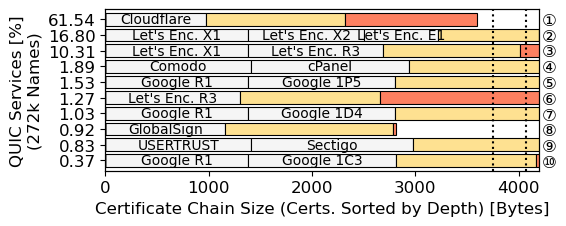

In [22]:
# prepase order, colors, labels
df_cols_filter = df_tls[df_tls["hash"].isin(col_order)]
dict_box_types =  df_cols_filter.groupby(["hash"])["type"].unique().to_dict()
bar_fill_colors = ["#F5F5F5"]*len(col_order) + ["#FEE191", "#FD8060",]
dict_box_labels = df_cols_filter.set_index("hash")["subjcn"].to_dict()

ax = df_pivot.plot.barh(stacked=True, color=bar_fill_colors, edgecolor="black", width=0.82,
                        legend=False, figsize=(8*0.7,3*0.7), linewidth=0.8)

# fix labels
ax.set_xlabel("Certificate Chain Size (Certs. Sorted by Depth) [Bytes]")
dict_ylabel = {
    "no_quic":   "Other Services",
    "only_quic": "QUIC Services",
}
ax.set_ylabel(f"{dict_ylabel[tls_mode]} [%]\n({round(df_tls['domain'].nunique(), -3)//1000}k Names)")
ax.set_yticklabels(list(df_fingerprint_cut["share_domains_str"])[::-1])

# we have a container for each certificate in the top parent chain
for i, container in enumerate(ax.containers):
    
    current_labels = []
    last_run = i>=len(col_order)
    
    for rect in container:
        
        if rect.get_width() > 0:
            
            if not last_run:
                my_label = dict_fingerprint_meta[col_order[i]]["short"]
            else:
                my_label = ""
            current_labels.append(my_label)
            
        else:
            current_labels.append("")
                  
    ax.bar_label(container, labels=current_labels, label_type='center', size="small")
    
ax.set_xlim(0, 4200)

# draw 3x limits
ax.axvline(1357*3, color="black", linestyle="dotted", alpha=1)
ax.axvline(1250*3, color="black", linestyle="dotted", alpha=1)

# add parent chain ID
dict_unicode_circled = {
    1:"①", 2:"②", 3:"③", 4:"④", 5:"⑤",
    6:"⑥", 7:"⑦", 8:"⑧", 9:"⑨", 10:"⑩",
}
ax2 = ax.twinx()
ax2.set_yticks(list(dict_unicode_circled.keys()))
ax2.set_yticklabels(reversed(dict_unicode_circled.values()))
ax2.yaxis.set_ticks_position('none')
ax2_offset = 0.62
ax2.set_ylim([1-ax2_offset,10+ax2_offset])
ax2.tick_params(axis='y', pad=-2)

# show and save
plt.show()
fig = ax.get_figure()
fig.savefig(f"./plots/stacked_bars_tls_heavy_chain_qual_{tls_mode}.png", bbox_inches='tight', dpi=200)
fig.savefig(f"./plots/stacked_bars_tls_heavy_chain_qual_{tls_mode}.pdf", bbox_inches='tight')
plt.close(fig)

### Textual output -- allows validation of (somehow hacky) matplotlib plot

In [23]:
# explode and stack plot should lead to the following chain orders
# lets manually explode that chain list and compare
for chain, share in zip(df_fingerprint_cut["hash"], df_fingerprint_cut["share_domains"]):

    print(f"----------- {share} -----------")
    print(dict_box_labels[chain[0]])
    
    if len(chain)>1:
        for i,cert in enumerate(chain[1:]):
            print(f"{'  '*(i+1)}{dict_box_labels[cert]}")

----------- 61.54265146440743 -----------
Cloudflare Inc ECC CA-3
----------- 16.803698005991592 -----------
ISRG Root X1
  ISRG Root X2
    E1
----------- 10.313785818912532 -----------
ISRG Root X1
  R3
----------- 1.8931670800915668 -----------
COMODO RSA Certification Authority
  cPanel, Inc. Certification Authority
----------- 1.5295494527333888 -----------
GTS Root R1
  GTS CA 1P5
----------- 1.2748698999683492 -----------
R3
----------- 1.0312313682769383 -----------
GTS Root R1
  GTS CA 1D4
----------- 0.9200850894690742 -----------
GlobalSign Domain Validation CA - SHA256 - G3
----------- 0.8266044443790161 -----------
USERTrust RSA Certification Authority
  Sectigo RSA Domain Validation Secure Server CA
----------- 0.36766600175184205 -----------
GTS Root R1
  GTS CA 1C3


# Compression Stats

In [24]:
df_compression.head()

,CLIENT_DOMAIN,CLIENT_ALGO,DECOMPRESS_ALGO,CERT_BYTES_COMPRESSED,CERT_BYTES_DECOMPRESSED
0,abzarmarket.com,brotli,brotli,4147.0,5675.0
1,pngguru.com,brotli,brotli,1630.0,2330.0
2,becomeablogger.com,brotli,brotli,1642.0,2341.0
3,nest.com,brotli,brotli,3373.0,4310.0
4,divxtotal.ms,brotli,brotli,3140.0,4208.0


In [25]:
# how many names support compression?
df_compression["DECOMPRESS_ALGO"].value_counts()/df_quic["domain"].nunique()*100

brotli    96.320008
zstd       0.049218
zlib       0.048116
Name: DECOMPRESS_ALGO, dtype: float64

In [26]:
# calc the compression rate
df_compression["COMPRESSION_RATE"] = df_compression["CERT_BYTES_COMPRESSED"] /\
                                        df_compression["CERT_BYTES_DECOMPRESSED"]

In [27]:
# what is the mean compression rate?
df_compression["COMPRESSION_RATE"].mean()*100

72.67468875935378

In [28]:
# compression difference across algos? (lower is better)
df_compression.groupby(["DECOMPRESS_ALGO"])["COMPRESSION_RATE"].mean().round(2).sort_values().to_frame()*100

,COMPRESSION_RATE
DECOMPRESS_ALGO,
zstd,72.0
brotli,73.0
zlib,74.0


In [29]:
# how often do we see support for all 3 algos?
sr_decompress_count = df_compression.groupby(["CLIENT_DOMAIN"])["DECOMPRESS_ALGO"].count()
sr_decompress_count.value_counts()

1    262109
0     10016
3       131
Name: DECOMPRESS_ALGO, dtype: int64

#### Check effects on limits

In [30]:
firefox_limit = 1357*3
firefox_limit

4071

In [31]:
(df_compression["CERT_BYTES_COMPRESSED"]>firefox_limit).value_counts(normalize=True)*100

False    99.825164
True      0.174836
Name: CERT_BYTES_COMPRESSED, dtype: float64

In [32]:
(df_compression["CERT_BYTES_DECOMPRESSED"]>firefox_limit).value_counts(normalize=True)

False    0.917347
True     0.082653
Name: CERT_BYTES_DECOMPRESSED, dtype: float64